In [53]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd

In [54]:
env = gym.make('FrozenLake-v0')
env.render() #상태 보여줌


SFFF
FHFH
FFFH
HFFG


In [55]:
state_space = env.observation_space.n #16 ->4*4
action_space = env.action_space.n #4
#print(input_size, output_size) #16 4

In [56]:
def one_hot(x,state_space):
    oh=torch.from_numpy(np.identity(state_space)[x:x + 1]) #float64 (double로 인식해서 오류남)
    return oh.float() #float32로 형변환

In [57]:
learning_rate=0.01 #이게문제였어!! 0.1로하니 정확도 엄청나게떨어짐.. 
dis=0.99 #전에 오히려 낮추니까 정확도 줄어들길래 일단..
num_episodes=5000

In [58]:
loss=nn.MSELoss()
model = nn.Sequential(nn.Linear(state_space, action_space, bias=False))
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

In [59]:
reward_list=[] # 에피소드마다 보상의 합 저장하는 리스트
step_list=[] #움직임 횟수
loss_list=[] #loss저장용

episodes 0 ----
episodes 500 ----
episodes 1000 ----
episodes 1500 ----
episodes 2000 ----
episodes 2500 ----
episodes 3000 ----
episodes 3500 ----
episodes 4000 ----
episodes 4500 ----
Percent of successful episodes: 31.36%


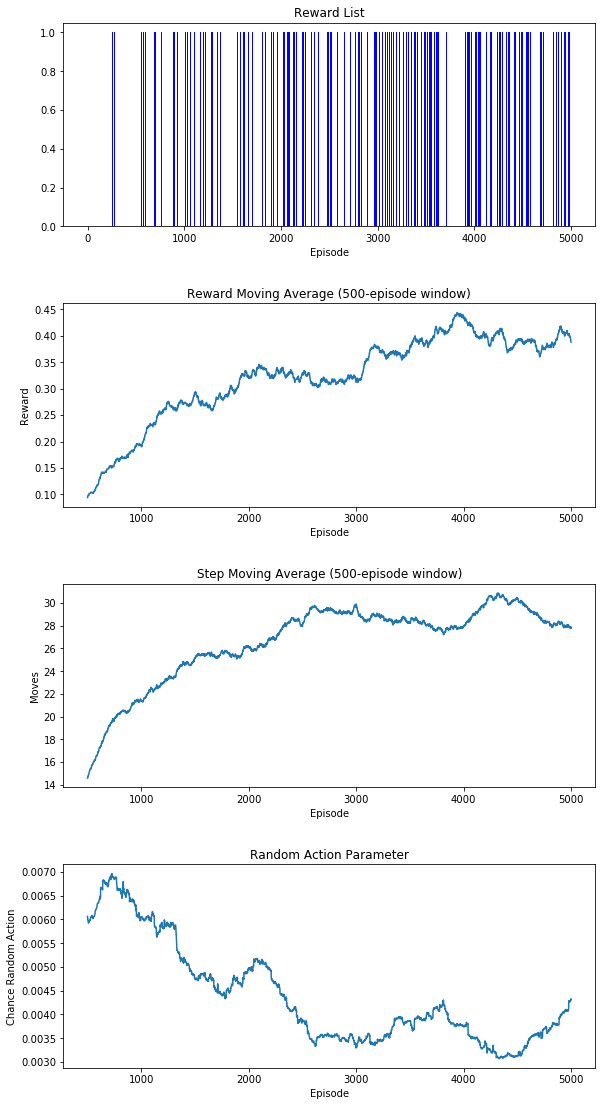

In [60]:
for i in range(num_episodes):
    if i % 500==0: #출력확인용
        print('episodes %d ----' %i)
        
    state=env.reset()
    e = 1. / ((i / 100) + 1)
    done=False
    reward_all=0
    step=-1
    l=0
    
    while not done and step<50: #너무 오래 걸리는 경우 학습X
        step+=1
        
        # E-Greedy 알고리즘
        if np.random.rand(1) > e : #랜덤으로 뽑은 숫자가 입실론보다 클 경우
            state=one_hot(state,state_space)
            state.requires_grad_(True)
            Q=model(state) # 4개의 action
            _,action = torch.max(Q,1) #4개 action 중 가장 큰 곳 선택, 우리가 필요한 것은 index
            action=action.data[0]
            action=action.item() #tensor to int

            
        else : 
            state=one_hot(state,state_space)
            state.requires_grad_(True)
            Q=model(state)
            action = env.action_space.sample() #랜덤하게 행동 결정
        
        #print(action)
        new_state, reward, done, _ = env.step(action)
        
            
        #Qnetwork
        Q1=model(one_hot(new_state,state_space))
        Q1.requires_grad_(True)
        mQ1,_=torch.max(Q1.data,1) #maxQ1값, index
        
        #Q업데이트, target Q
        updateQ=Q.data #requires_grad=False(자동임)
        
        
        if done: #goal or hole에 빠짐
            updateQ[0,action]=reward #terminal state
        else:
            updateQ[0,action]=reward+mQ1*dis
        
        output = model(state)
        train_loss = loss(output, updateQ)

        l+=train_loss.item()
        
        #학습
        model.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        reward_all+=reward
        state=new_state
        
    reward_list.append(reward_all)
    step_list.append(step)
    loss_list.append(l/step)

plt.figure(figsize=[9,16])
print("Percent of successful episodes: " +
      str(sum(reward_list) / num_episodes*100) + "%")
plt.subplot(411)
plt.bar(range(len(reward_list)), reward_list, color="blue")
plt.title('Reward List')
plt.xlabel('Episode')

window = int(num_episodes/10) 
plt.subplot(412)
plt.plot(pd.Series(reward_list).rolling(window).mean()) #가로 에피소드 세로 보상
plt.title('Reward Moving Average ({}-episode window)'.format(window))
plt.ylabel('Reward')
plt.xlabel('Episode')

plt.subplot(413)
plt.plot(pd.Series(step_list).rolling(window).mean()) #가로 에피소드 세로 횟수
plt.title('Step Moving Average ({}-episode window)'.format(window))
plt.ylabel('Moves')
plt.xlabel('Episode')

plt.subplot(414)
plt.plot(pd.Series(loss_list).rolling(window).mean()) #가로 에피소드 세로 loss
plt.title('Random Action Parameter')
plt.ylabel('Chance Random Action')
plt.xlabel('Episode')

plt.tight_layout(pad=3) #그래프간 간격
plt.show()